# Project: Red Wine Quality - Explanatory Model

## Context
The  dataset is related to red variant of the Portuguese "Vinho Verde" wine. For more details, consult the reference (Cortez et al., 2009). Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).


This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality

Reference:\
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

## Content
According to dataset provider, there are no missing values in the data set.\
**Independent variables/ features (based on physicochemical tests):**\
1 - fixed acidity\
2 - volatile acidity\
3 - citric acid\
4 - residual sugar\
5 - chlorides\
6 - free sulfur dioxide\
7 - total sulfur dioxide\
8 - density\
9 - pH\
10 - sulphates\
11 - alcohol\
**Output, dependent variable (based on sensory data):**\
12 - quality (score between 0 and 10)

### GOAL 1: Identifying key factors influencing wine quality

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor as VIF
)
from sklearn.metrics import mean_squared_error, r2_score
from ISLP.models import ModelSpec as MS, summarize
import scipy.stats as stats

## Dataset overview

### Sample of Red wine quality dataset

In [2]:
wine_df = pd.read_csv("winequality-red.csv")
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


- no null values
- all feature have numeric, float elements (except quality with integer elements which is justified by the way of data capturing)
- 1599 types of red wines were compared and tested

### Checking for duplicated rows

In [4]:
wine_df.duplicated().sum()

240

- There are 240 duplicated rows which might influence further analysis!!

#### Removing duplicated rows

In [5]:
wine_df = wine_df.drop_duplicates()

### Basic statistical properties of features below:

In [6]:
wine_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.0,8.310596,1.736990,4.60000,7.1000,7.9000,9.20000,15.90000
volatile acidity,1359.0,0.529478,0.183031,0.12000,0.3900,0.5200,0.64000,1.58000
citric acid,1359.0,0.272333,0.195537,0.00000,0.0900,0.2600,0.43000,1.00000
residual sugar,1359.0,2.523400,1.352314,0.90000,1.9000,2.2000,2.60000,15.50000
chlorides,1359.0,0.088124,0.049377,0.01200,0.0700,0.0790,0.09100,0.61100
free sulfur dioxide,1359.0,15.893304,10.447270,1.00000,7.0000,14.0000,21.00000,72.00000
total sulfur dioxide,1359.0,46.825975,33.408946,6.00000,22.0000,38.0000,63.00000,289.00000
density,1359.0,0.996709,0.001869,0.99007,0.9956,0.9967,0.99782,1.00369
pH,1359.0,3.309787,0.155036,2.74000,3.2100,3.3100,3.40000,4.01000
sulphates,1359.0,0.658705,0.170667,0.33000,0.5500,0.6200,0.73000,2.00000


- Although maximum score range of wine quality is between 0 and 10, we can observe only **range  between 3 and 8**
- Minimal value for citric acid is 0 which may be valid result but on the other hand may be caused by missing/null values

### Sample distributions of individual features
#### Boxplots

Visualizing the distribution of elements for each feature and identifying outliers, which aids in assessing data quality and determining whether certain elements should be excluded.

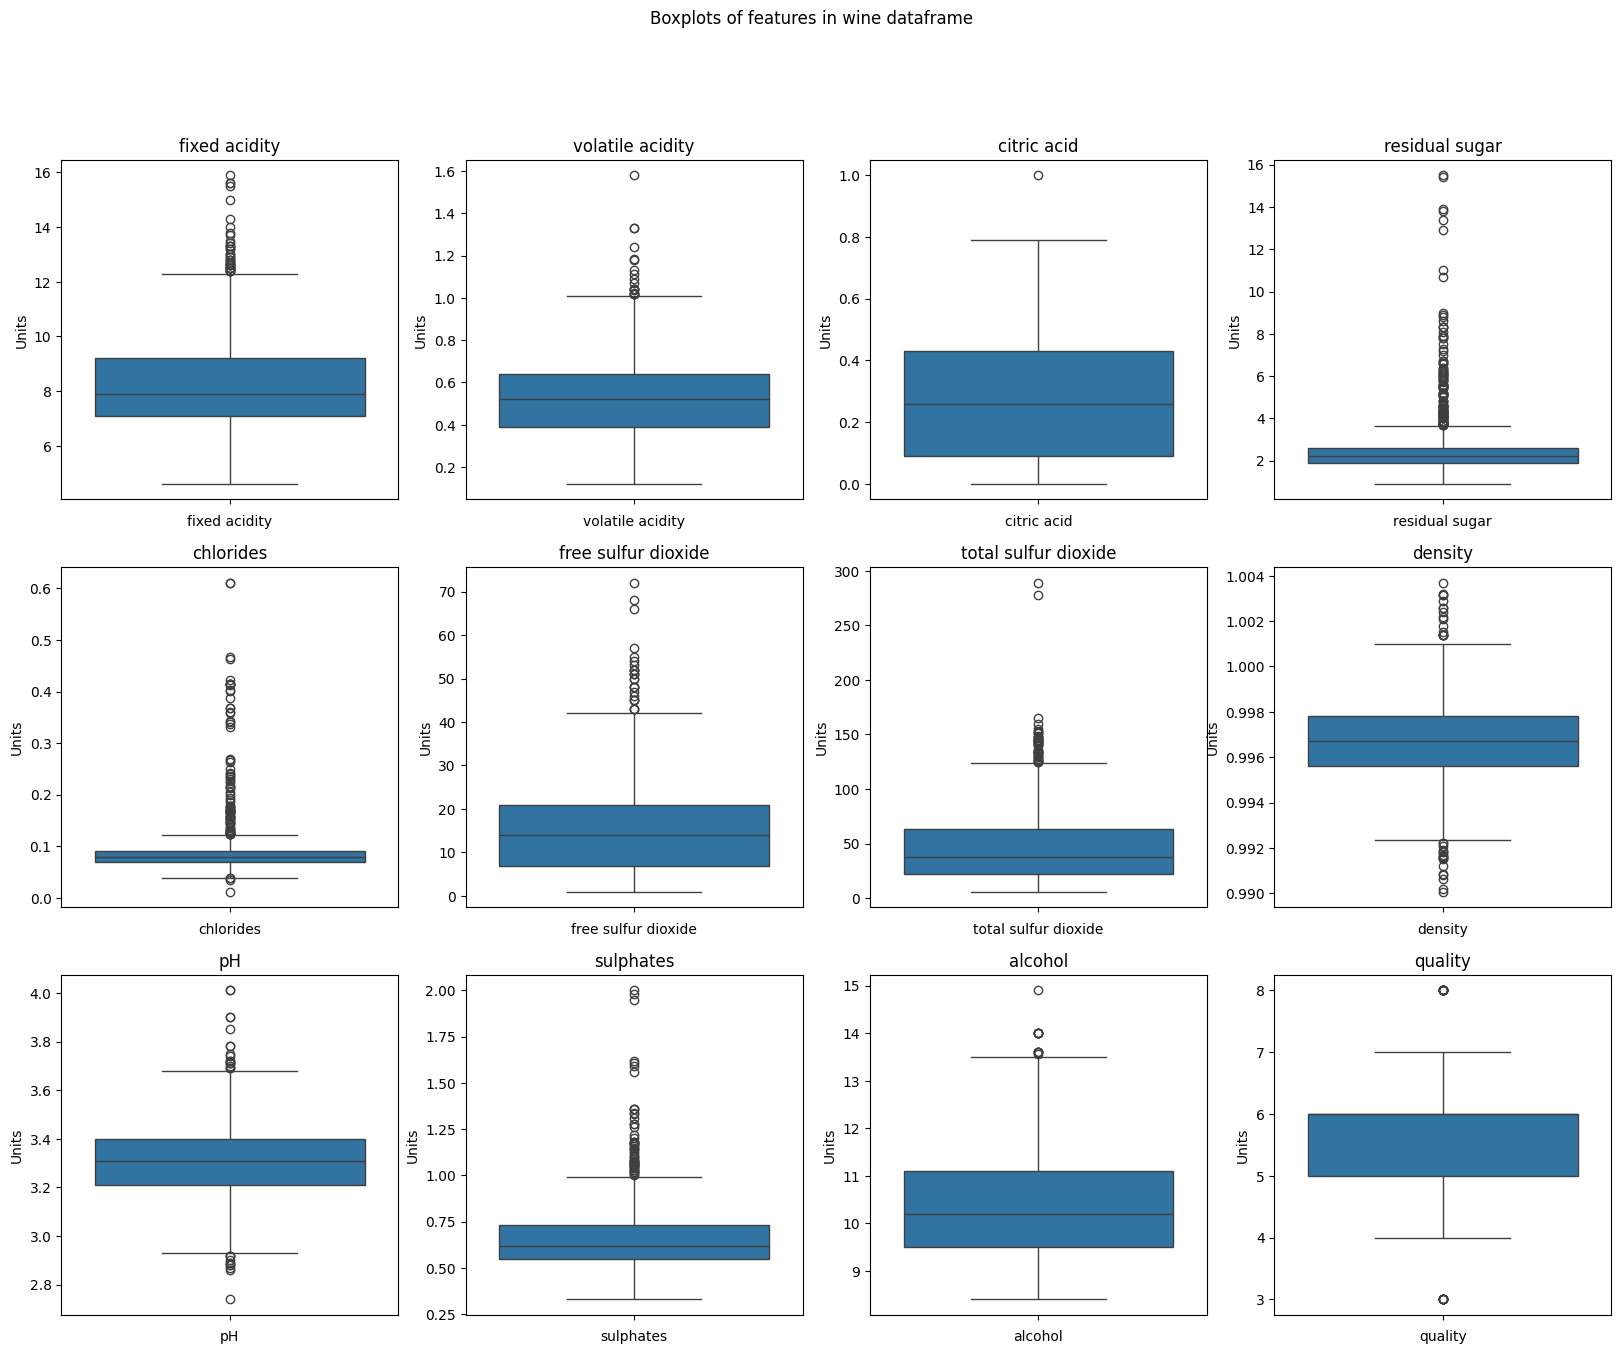

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows, 4 columns
axes = axes.flatten()
fig.suptitle("Boxplots of features in wine dataframe")
for i, column in enumerate(wine_df.columns):
    sns.boxplot(wine_df[column], ax=axes[i])
    axes[i].set_title(f"{column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Units")

- Although, all of features have some outliers, they will not be excluded. In general most of features have outliers no more than 6 times the median (smaller or bigger), There are no reasonable suspicion that outliers are untrue or not probable.

#### Histograms
Histograms help identify data patterns and assess the distribution of elements across all features in the dataset

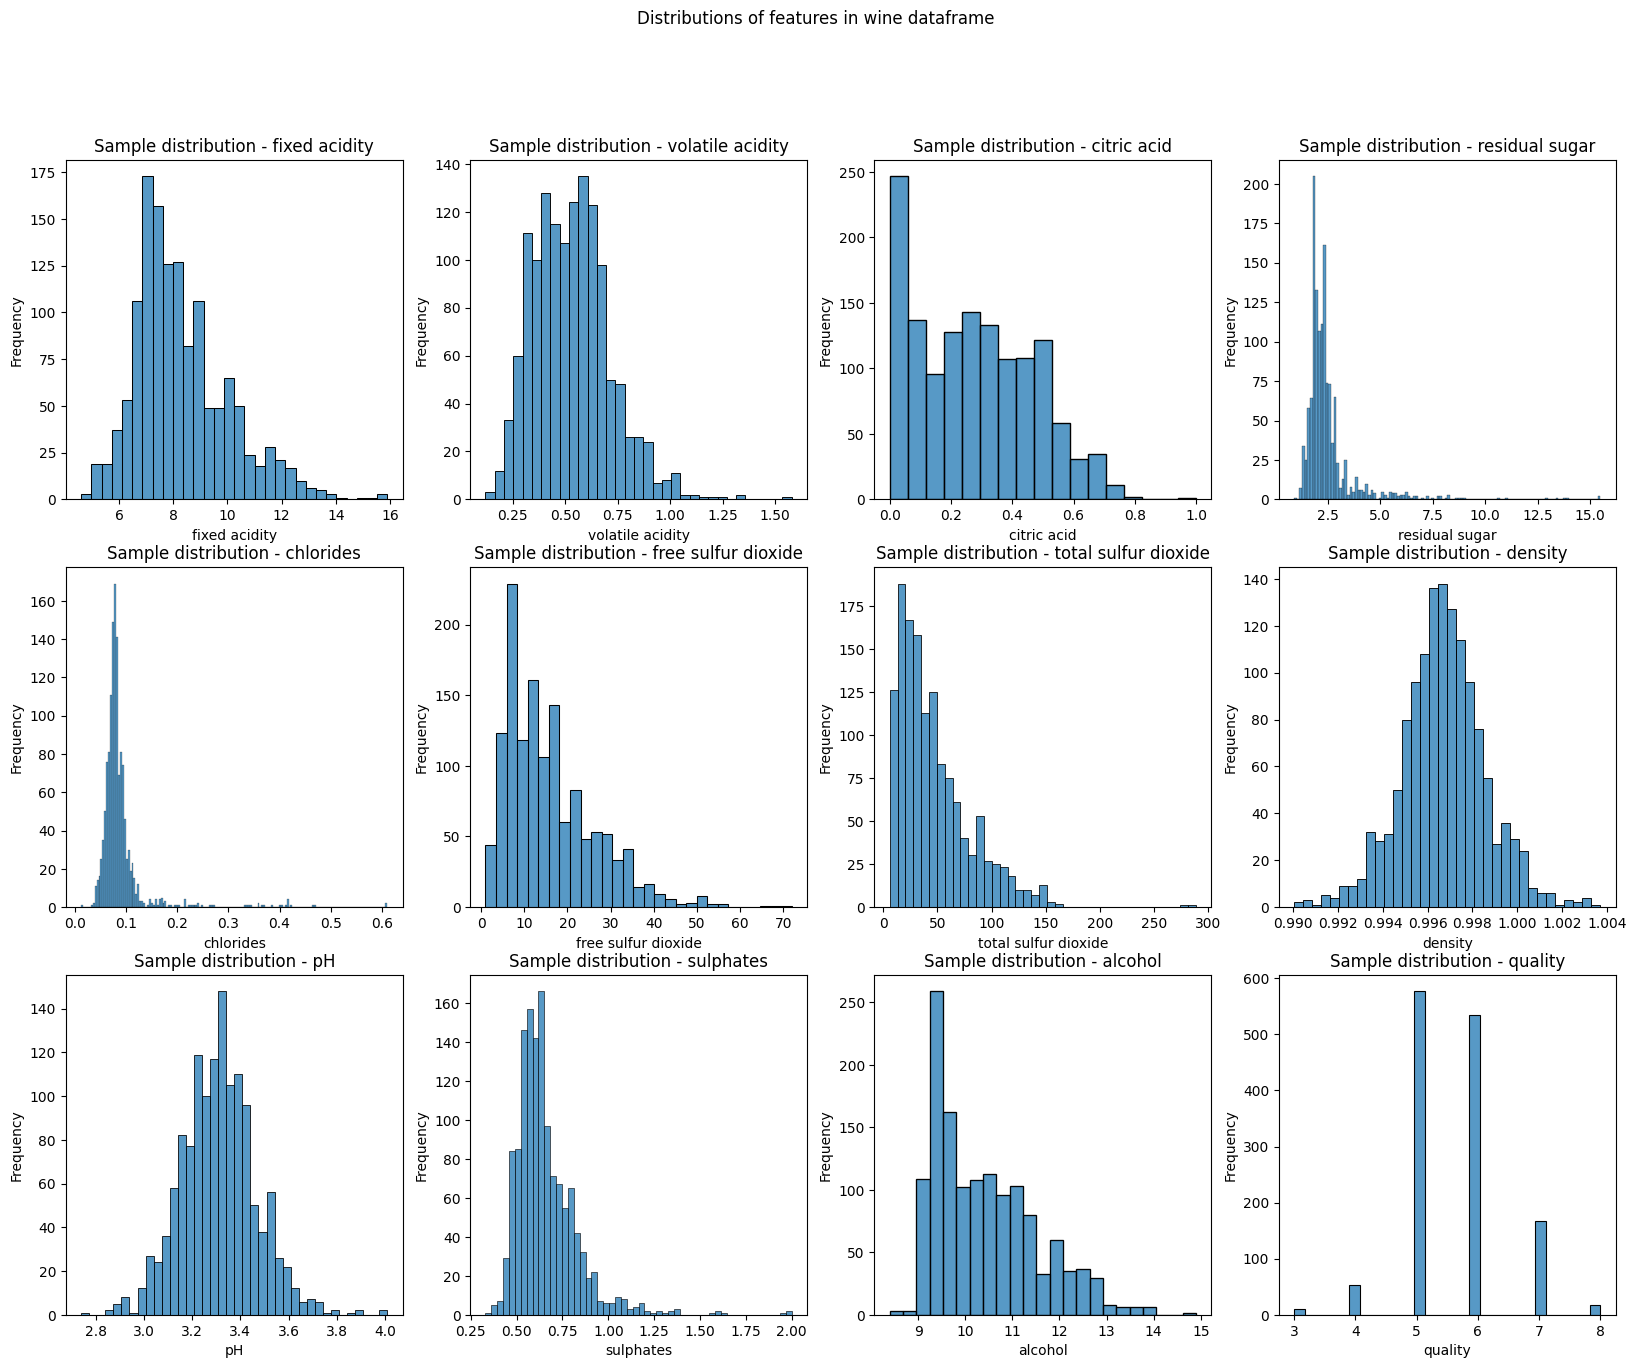

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distributions of features in wine dataframe")
for i, column in enumerate(wine_df.columns):
    sns.histplot(wine_df[column], ax=axes[i])
    axes[i].set_title(f"Sample distribution - {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")

- All features in wine data frame are approximately normally distributed.
- Some of features have slightly right skewed distribution but based on **Central Limit Theorem** and the fact that sample size is >30, we can assume that it is still an approximately normal distribution.
- Additionally, observing the SD and the long right tail (outliers) of sugar residual histogram, we can guess that most of wines were dry however some of them (minority - outliers) had much more sugar and might be semi-dry or even sweet. Due to this decision we can model the impact of sugar residual on quality.

### Correlation heatmap
Starting from the Pearson's standard correlation coefficient in order to show the dependencies between features

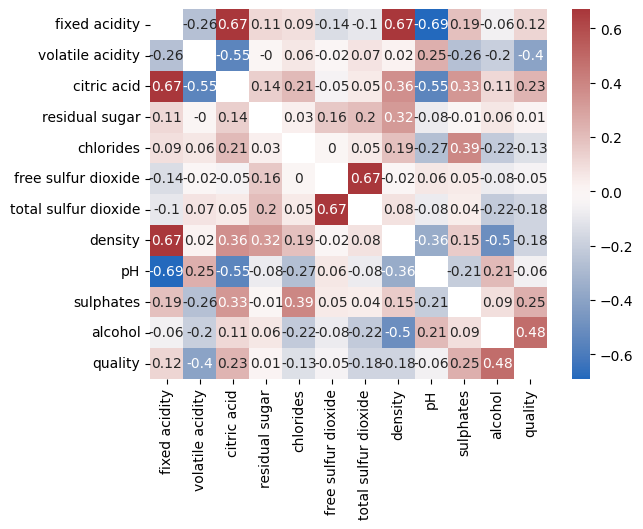

In [31]:
correlation_matrix = wine_df.corr().round(2)
correlation_matrix *= 1 + np.diag(np.nan * np.ones(12))
sns.heatmap(data=correlation_matrix, annot=True, cmap="vlag");

- Focusing on quality raw, we can extract some physicochemical and sensory wine features which are moderately correlated with wine quality:
    - volatile acidity (negative correlation)
    - alcohol (positive correlation)\
Other wine features poorly correlated with quality:
    - citric acid (positive correlation)
    - sulphates (positive correlation)
    - total sulfur dioxide (negative correlation)
- Beside correlations with quality, there is some multicollinearity - some independent variables are highly correlated with each other Eg:
    - **citric acid** is negatively correlated with **pH** (Acid lowers the pH)
    - **fixed acidity** is negatively correlated with **pH** and positively with **citric acid** and **density**
    - **volatile acidity** is negatively correlated with **citric acid**
    - **total sulfur dioxide** is positively correlated with **free sulfur dioxide**
    - **density** is negatively correlated with **alcohol**\
Most of the correlation comes from the chemical properties

### Trends of wine quality vs independent variables 

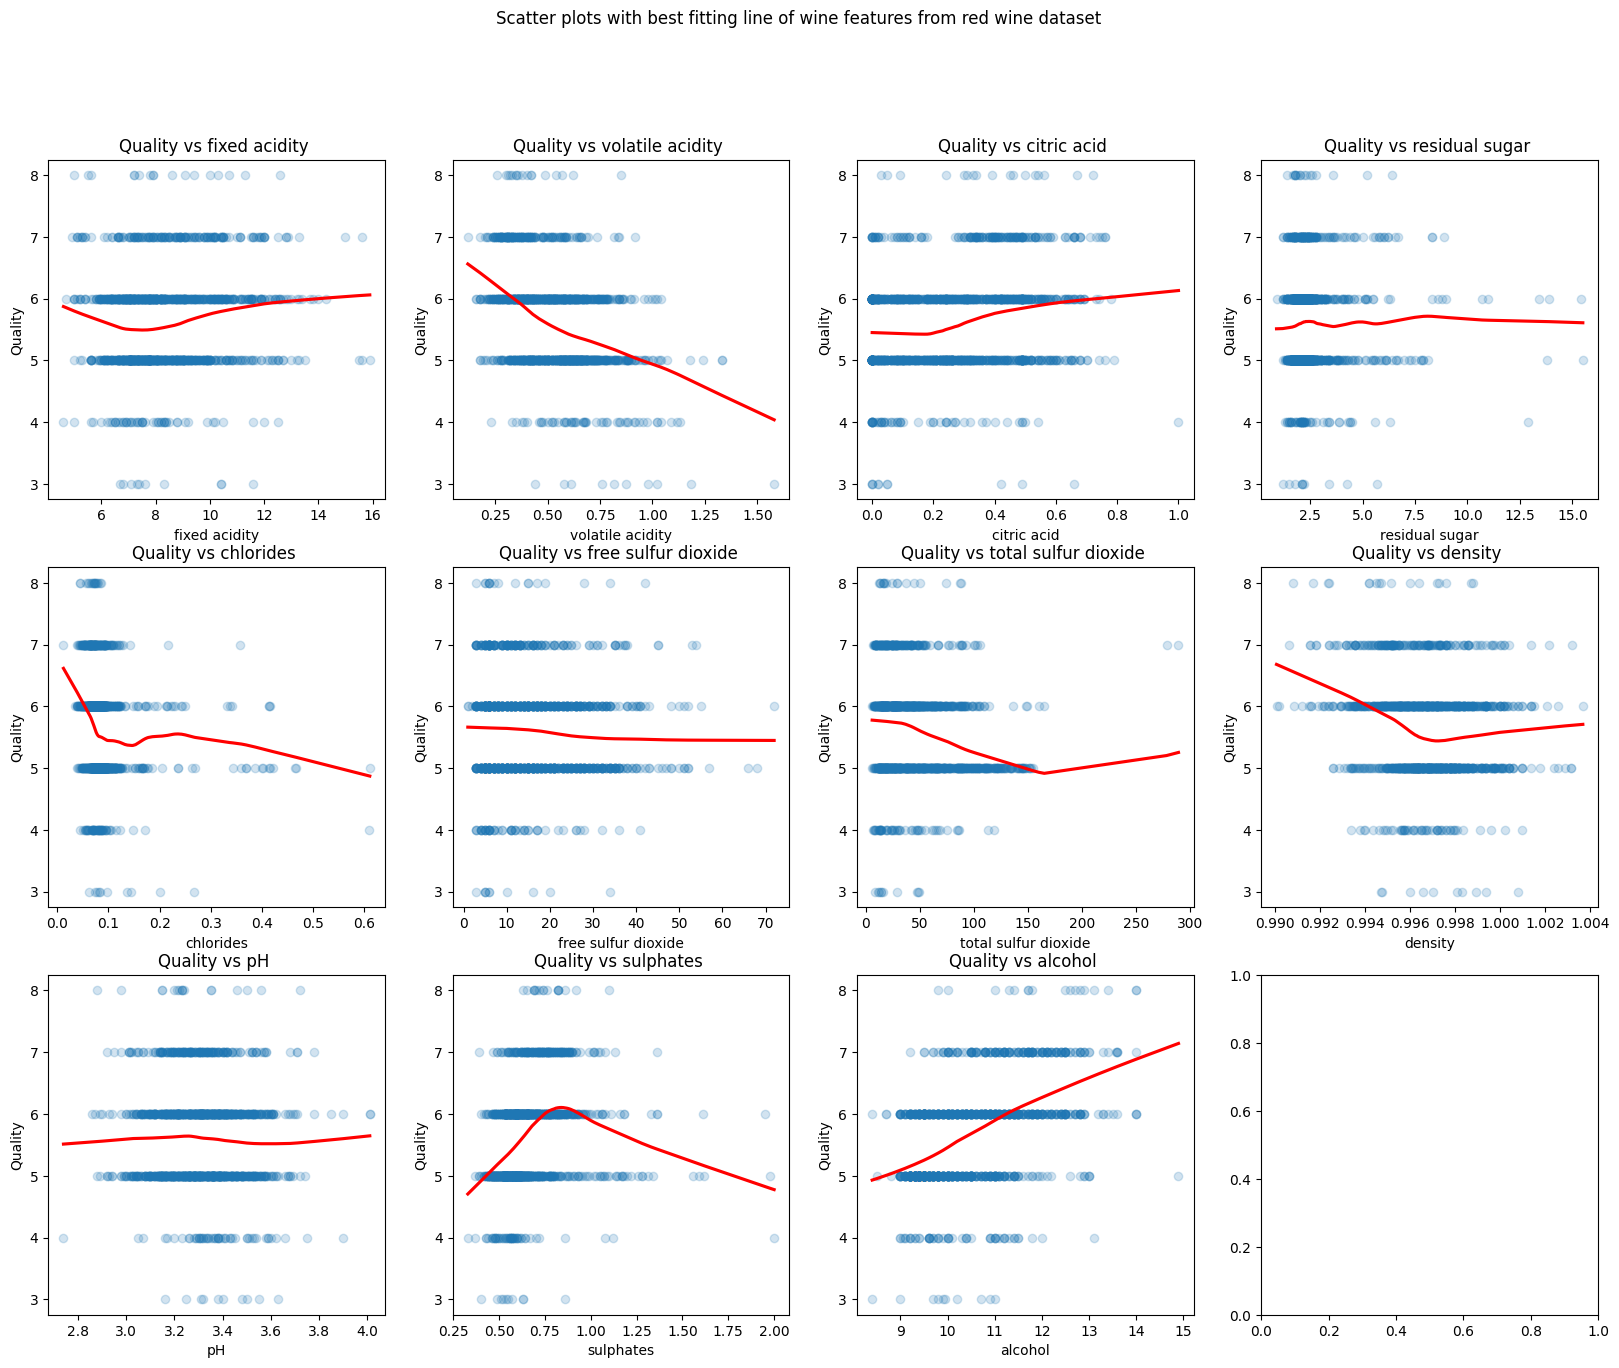

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle(
    "Scatter plots with best fitting line of wine features from red wine dataset"
)
for i, column in enumerate(wine_df.columns):
    if column in ["quality"]:
        continue
    sns.regplot(
        x=column,
        y="quality",
        data=wine_df,
        lowess=True,
        scatter_kws={"alpha": 0.2},
        line_kws={"color": "red"},
        ax=axes[i],
    )
    axes[i].set_title(f"Quality vs {column} ")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Quality")

- There are various visible relationships between independent variables and wine quality. Some of them are constant, some decreasing some increasing.
- To assess the significance of various factors on wine quality, a **linear regression** model is a good choice as it provides an interpretable framework to quantify relationships between independent variables and the dependent variable (wine quality). 
- Because of the non-linear data for some features (fixed acidity, chlorides, total sulfur dioxide, density and sulphates), additional transformations in the linear model might be needed.

## Explanatory modeling
Further analysis will focus on identifying key factors influencing wine quality using linear regression modeling.
### GOAL 2: Does alcohol concentration increase wine quality?
The main hypothesis of the analysis is whether coefficient of the alcohol ($\beta_a$) in multi-linear regression model is non-zero. In other words - Does alcohol concentration increase wine quality?

$H_0$: $\beta_a$ = 0\
$H_a$: $\beta_a$ $\neq$ 0 

### Separating training and testing data (80/20)
In order to test performance of the linear regression model later, we separate test data from training data beforehand in proportion 80/20: train data/test data

In [11]:
test_df = wine_df.sample(frac=0.2, random_state=2)
train_df = wine_df.drop(test_df.index)

### Model 1 - Fitting the Ordinary Least Squares (OLS) regression Multi-linear model with all independent variables

In [12]:
train_df_minus = train_df.columns.drop(["quality"])
y = train_df["quality"]
X = MS(train_df_minus).fit_transform(train_df)
multi_lin_all_model = sm.OLS(y, X)
multi_lin_all_results = multi_lin_all_model.fit()

#### Evaluating Performance of Model 1

In [13]:
multi_lin_all_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     54.27
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           2.90e-95
Time:                        16:29:54   Log-Likelihood:                -1086.5
No. Observations:                1087   AIC:                             2197.
Df Residuals:                    1075   BIC:                             2257.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept               10.8211     26.786      0.404      0.686     -41.737      63.380
fixed acidity            0.0121      0.033      0.370      0.711      -0.052       0.076
volatile acidity        -1.0709      0.148     -7.243      0.000      -1.361      -0.781
citric acid             -0.0984      0.181     -0.545      0.586      -0.453       0.256
residual sugar           0.0052      0.019      0.270      0.787      -0.032       0.043
chlorides               -2.3033      0.513     -4.489      0.000      -3.310      -1.296
free sulfur dioxide      0.0011      0.003      0.419      0.675      -0.004       0.006
total sulfur dioxide    -0.0020      0.001     -2.247      0.025      -0.004      -0.000
density                 -6.6307     27.328     -0.243      0.808     -60.253      46.991
pH                      -0.4572      0.243     -1.885      0.060      -0.933       0.019
sulphates                0.9679      0.145      6.697      0.000       0.684       1.251
alcohol                  0.2937      0.033      8.870      0.000       0.229       0.359
==============================================================================
Omnibus:                       26.833   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.654
Skew:                          -0.246   Prob(JB):                     4.04e-09
Kurtosis:                       3.782   Cond. No.                     1.17e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Residual standard error (RSE)

In [14]:
RSE = np.sqrt(multi_lin_all_results.scale)
print(
    f"The percentage error of predicted quality with current linear model is approximately: {round(RSE / test_df['quality'].mean() * 100, 2)} %"
)

The percentage error of predicted quality with current linear model is approximately: 11.83 %


- According to Conditional number, there are multicollinearity 
- p-values of features: fixed acidity, citric acid, residual sugar, free sulfur dioxide, density and pH are > 0.05, they might not influence significantly on red wine quality.
- F-statistic and it's probability < 0.05, support the hypothesis that some of the features impact on red wine quality statistically significant.
- $R^2$ is low - regression model explain at least around 35 % of variability in red wine quality
- Feature selection can be performed

##### Variance inflation factor (VIF)
Checking for high correlations between independent variables

In [15]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({"vif": vals}, index=X.columns[1:])
vif

,vif
fixed acidity,8.025221
volatile acidity,1.767699
citric acid,3.093385
residual sugar,1.636281
chlorides,1.593198
free sulfur dioxide,1.965277
total sulfur dioxide,2.237048
density,6.115661
pH,3.442393
sulphates,1.522274


- VIF analysis reveal some multicollinearity between variables and show the importance of excluding some features from model building.

### Deciding on Important Variables (Backward elimination)
Because of 11 red wine independent variables and some irrelevant among them, it is important to find the most valuable features which make an impact on dependent feature - quality
**Backward elimination method** will be used in order to select variables with p-value under 0.05.
#### Backward elimination function
Creating a function which eliminates features from multiple linear regression model until all features will have p-value <0.05

In [16]:
def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if max_p_value >= significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features


data = train_df.drop(columns="quality")
target = train_df["quality"]

selected_features_list = backward_elimination(data, target)

Selected features below:

In [17]:
selected_features_list

['volatile acidity',
 'chlorides',
 'total sulfur dioxide',
 'pH',
 'sulphates',
 'alcohol']

- Selected features correspond with those selected using correlation heatmap.


### Model 2 - Fitting the Ordinary Least Squares (OLS) regression Multi-linear model with selected independent variables

In [18]:
y = train_df["quality"]
X = MS(selected_features_list).fit_transform(train_df)
multi_lin_model2 = sm.OLS(y, X)
multi_lin_results2 = multi_lin_model2.fit()

#### Evaluating Performance of Model 2

In [19]:
multi_lin_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     99.79
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          6.78e-100
Time:                        16:29:54   Log-Likelihood:                -1086.9
No. Observations:                1087   AIC:                             2188.
Df Residuals:                    1080   BIC:                             2223.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                4.3265      0.500      8.646      0.000       3.345       5.308
volatile acidity        -1.0396      0.123     -8.460      0.000      -1.281      -0.798
chlorides               -2.3955      0.483     -4.959      0.000      -3.343      -1.448
total sulfur dioxide    -0.0018      0.001     -2.991      0.003      -0.003      -0.001
pH                      -0.4763      0.146     -3.273      0.001      -0.762      -0.191
sulphates                0.9599      0.139      6.916      0.000       0.688       1.232
alcohol                  0.2978      0.021     14.236      0.000       0.257       0.339
==============================================================================
Omnibus:                       25.681   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.273
Skew:                          -0.243   Prob(JB):                     1.33e-08
Kurtosis:                       3.752   Cond. No.                     1.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Residual standard error (RSE)

In [20]:
RSE = np.sqrt(multi_lin_results2.scale)
print(
    f"The percentage error of predicted quality with current linear model is approximately: {round(RSE / test_df['quality'].mean() * 100, 2)} %"
)

The percentage error of predicted quality with current linear model is approximately: 11.81 %


- Compared to previous model:
    - All selected features have coefficients significantly different than 0 (p-values <0.05)
    - $R^2$ and RSE is approximately the same,
    - The condition number strongly decreased, 
    - F-statistic almost doubled,
    - The condition number decreased 100-fold
- The condition number is still large which might indicate that there are still strong multicollinearity or other numerical problems.

##### Variance inflation factor (VIF)
Checking for high correlation between independent variables

In [21]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({"vif": vals}, index=X.columns[1:])
vif

,vif
volatile acidity,1.226193
chlorides,1.417678
total sulfur dioxide,1.058580
pH,1.243686
sulphates,1.409464
alcohol,1.217309


- Since VIF for all selected independent variables are close to 1, there are no clear evidence of collinearity among selected features.

##### Normality test of residuals distribution
Sanity check for normal distribution with residuals histogram

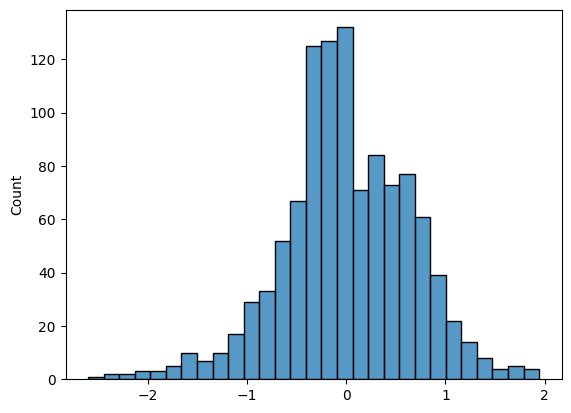

In [22]:
sns.histplot(multi_lin_results2.resid);

- Residuals are approximately normally distributed

Shapiro-Wilk normality test:

In [23]:
stats.shapiro(multi_lin_results2.resid)

ShapiroResult(statistic=0.9889554381370544, pvalue=2.695422551823867e-07)

- Since pvalue < 0.05, residuals are approximately normally distributed

QQplot:

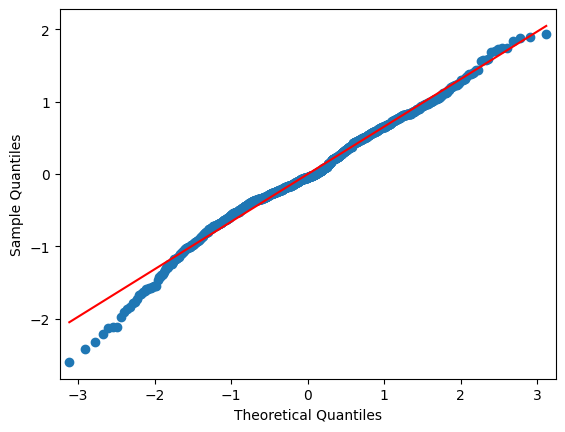

In [24]:
sm.qqplot(multi_lin_results2.resid, line="s");

- Residuals slightly deviate the ideal normal distribution

##### Pairplot of selected variables and wine quality

Here we should focus on collinearity between independent variables and non linear trends for independent variable vs quality

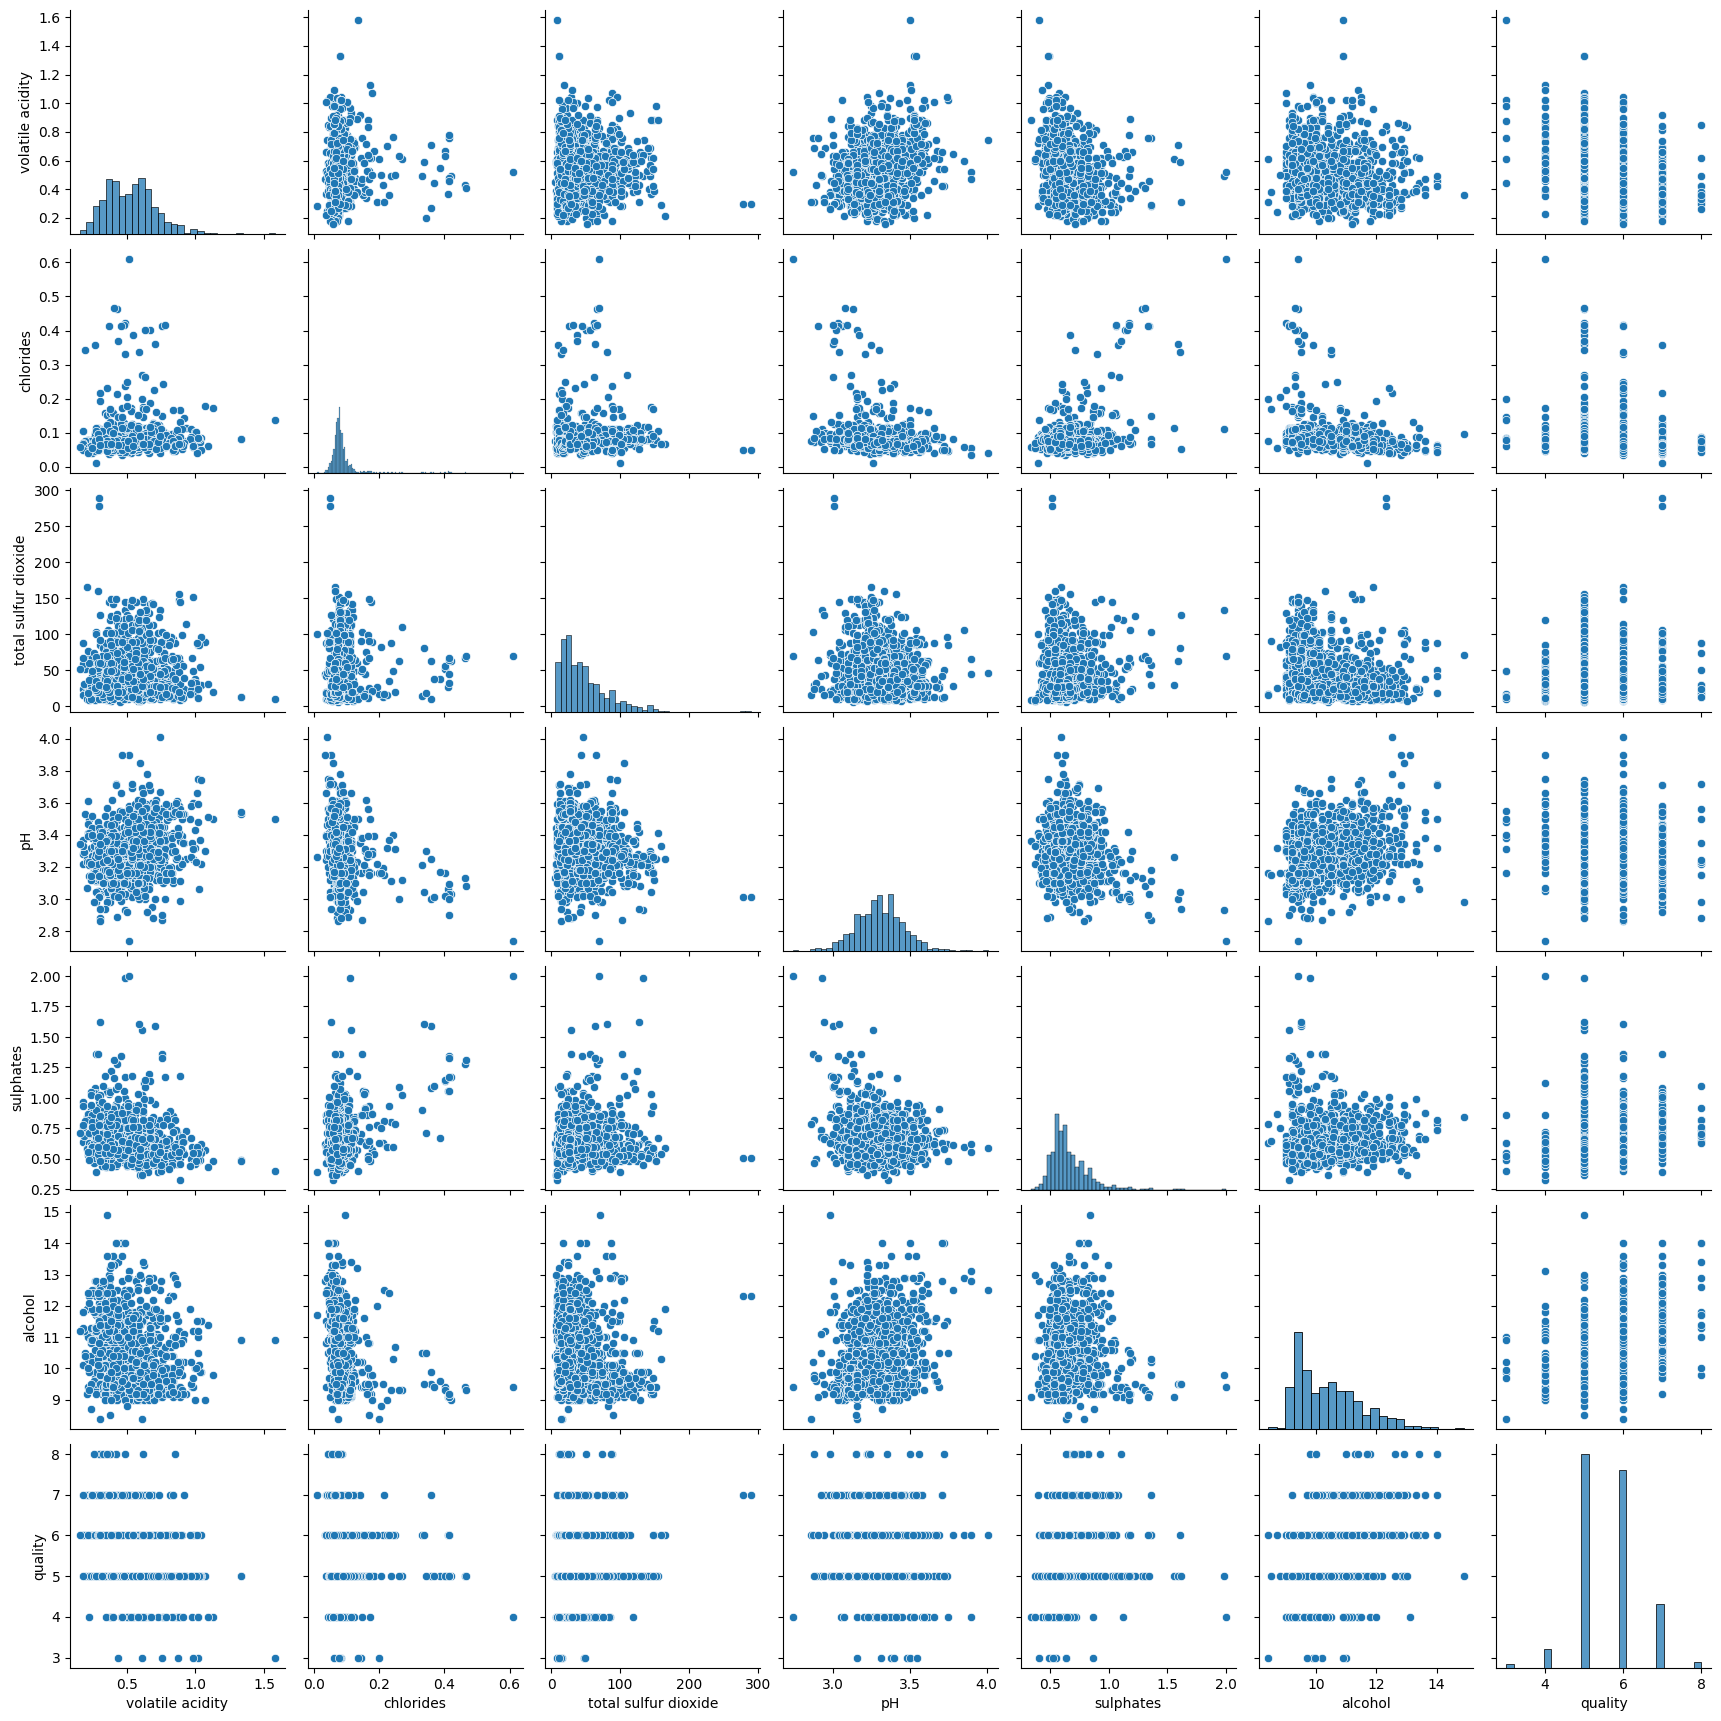

In [25]:
a = selected_features_list + ["quality"]
sns.pairplot(train_df[a]);

1. Collinearity was noticed between:
    - alcohol and pH
    - alcohol and sulphates
2. Non-linearity was noticed in:
    - sulphates
    - chlorides

#### Testing Model 2 performance using test dataset

Creating a predictions for quality score based on independent variables in test dataset

In [26]:
X_test_const = sm.add_constant(test_df[selected_features_list])
y_pred = multi_lin_results2.predict(X_test_const)

Comparing RMSE (Root Mean Squared Error) and $R^2$ for predicted quality scores and the real ones

In [27]:
# Training dataset:
MSE_train = np.mean(multi_lin_results2.resid**2)
RMSE_train = MSE_train**0.5
R2_train = multi_lin_results2.rsquared
print(f"Evaluation metrics for training dataset:\nR^2: {round(R2_train, 3)}\nRMSE: {round(RMSE_train, 3)}\n")

# Testing dataset (predictions):
MSE_test = mean_squared_error(test_df["quality"], y_pred)
RMSE_test = MSE_test**0.5
R2_test = r2_score(test_df["quality"], y_pred)
print(f"Evaluation metrics for testing dataset (predictions):\nR^2: {round(R2_test, 3)}\nRMSE: {round(RMSE_test, 3)}")

Evaluation metrics for training dataset:
R^2: 0.357
RMSE: 0.658

Evaluation metrics for testing dataset (predictions):
R^2: 0.376
RMSE: 0.66


- The **RMSE** value indicates that the model's predictions deviate from the actual wine quality scores by an average of approximately 0.66 points. On a scale of 0–10, this represents a reasonably low error.
- **$R^2$** is similar to one obtained on training dataset. $R^2$ value indicates that 37.6% of the variance in wine quality scores is explained by the model. While this shows the model captures a meaningful portion of the variance, 62.4% of the variance remains unexplained. This suggests that:
    - The physicochemical variables have a moderate but not dominant influence on wine quality.
    - There may be other influential factors (e.g., grape type, winemaking techniques, or external factors) that are not captured in the dataset.

## Answering the goals 
In summary, since prediction of quality score was reasonable and satisfying we can answer our main goals of the analysis
### GOAL 1: Identifying key factors influencing wine quality

In [28]:
print("Key factors influencing wine quality are:\n")
for factor in selected_features_list:
    print(factor)

Key factors influencing wine quality are:

volatile acidity
chlorides
total sulfur dioxide
pH
sulphates
alcohol


### GOAL 2: Does alcohol concentration increase wine quality?

In [29]:
sum = summarize(multi_lin_results2)
sum.loc[["alcohol"]]

,coef,std err,t,P>|t|
alcohol,0.2978,0.021,14.236,0.0


Since p-value for alcohol coefficient is <0.05, with 95% of confidence, alcohol coefficient is above zero and between 0.257 and 0.339. It means that with fixed features (volatile acidity, chlorides, total sulfur dioxide, pH, sulphates) for every 1 unit increase in alcohol concentration, there will be on average increase in red wine quality about 0.2978 score. 

We can reject $H_0$: $\beta_a$ = 0 and accept $H_a$: $\beta_a$ $\neq$ 0.\
Alcohol concentration,  increase red wine quality statistically significant.

Linear regression for quality vs alcohol in single linear model.

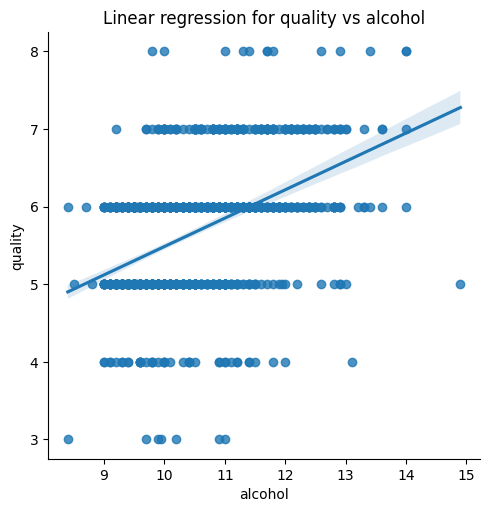

In [30]:
sns.lmplot(x="alcohol", y="quality", data=train_df)
plt.title("Linear regression for quality vs alcohol");

### Summary of Model 2 Performance
- Strengths: The model achieves on test dataset a low error (RMSE ≈ 0.66) relative to the scale of the target variable, indicating reasonably accurate predictions.
- Limitations:
$R^2$ value highlights that a significant portion of the variability in wine quality is not explained by the physicochemical variables alone. For applications requiring a high level of predictive accuracy, further improvement or inclusion of additional features might be necessary.


## Further improvements:
- Feature Engineering:\
Explore transformations or interactions between features (e.g., combining variables like pH and acidity).
- Data Augmentation:\
Include additional data related to grape type, fermentation conditions, or sensory evaluations if available.
- Model Optimization:\
Test non-linear models or ensemble methods (e.g., Random Forests, Gradient Boosting) to potentially improve $R^2$. Potential non-liniarity was noticed in sulphates and chlorides features. Polynomial functions for eg. sulphates may be implemented.
- Residuals:\
Check residuals for patterns to identify areas where the model might systematically under- or over-predict.
By addressing these aspects, the model could achieve better performance metrics and explain more of the variance in wine quality.
- Outliers:\
Test if excluding some outliers may improve the model.